## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy import constants
import seaborn as sns
import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle as ls
import lightkurve as lk
from astropy.io import fits


from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants as c
from scipy import stats

import pymc as pm
import pymc_ext as pmx
import arviz as az
from celerite2.pymc import GaussianProcess, terms
import pytensor.tensor as pt
%matplotlib inline

In [2]:
mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

mpl.rcParams['font.size'] = SMALL_SIZE          # controls default text sizes
mpl.rcParams['axes.titlesize'] = SMALL_SIZE     # fontsize of the axes title
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE    # fontsize of the x and y labels
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
mpl.rcParams['legend.fontsize'] = SMALL_SIZE    # legend fontsize
mpl.rcParams['figure.titlesize'] = BIGGER_SIZE  # fontsize of the figure title

## System parameters

In [3]:
# from exoplanet.eu catalog: https://exoplanet.eu/catalog/lp_714_47_b--7534/#publication_21546
# Dreizler et al 2020: https://www.aanda.org/articles/aa/full_html/2020/12/aa38016-20/aa38016-20.html
# exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=70899085
TIC_ID = 70899085

epoch_tess = ufloat(2459196.115341, 0.0005086)
period_tess = ufloat(4.0520368, 0.0000044)
duration_tess = 1.5605127851947
strad_tess = ufloat(0.607, 0.018)
stmass_tess = ufloat(0.594, 0.020)
stteff_tess = ufloat(3779, 157)

mass_pub = ufloat(0.0969, 0.0047)*u.M_jup.to(u.M_earth)
period_pub = ufloat(4.052037, 4e-06) # days
e_pub = ufloat(0.04, 0.02)
K_pub = ufloat(17.6, 0.8) # m/s
epoch_pub = ufloat(0.38421+58438, 0.00025)
radius_pub = ufloat(4.7, 0.3) # R_earth
stteff_pub = ufloat(3950, 51)
strad_pub = ufloat(0.584, 0.016)
stmass_pub = ufloat(0.59, 0.02)

stteff = ufloat(4123.30, 43.68)
strad = ufloat(0.536, 0.012)
stmass = ufloat(0.542, 0.001)
star_name = 'TOI-442'

# our parameters from Spirou spectra analysis
par = pd.read_table('./data/stellar_params.dat', sep=None, engine='python', header=0, skiprows=1)
par

,star,teff,teff_err,logg,logg_err,M/H,M/H_err,alpha,alpha_err,vmic,vmic_err,L,L_err,R,R_err,M,M_err
0,TOI-442,4123.3,43.68,4.60,0.08,0.05,0.1,0.13,0.10,1.05,0.34,0.07500,0.00100,0.536,0.012,0.542,0.001
1,TOI-4438,3501.0,70.01,4.67,0.11,0.07,0.1,-0.08,0.08,2.35,0.42,0.01706,0.00007,0.355,0.014,0.350,0.018


## Read LCs

In [4]:
#exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=70899085

# tpf_search = lk.search_targetpixelfile('TIC 70899085')
# tpf_search

In [5]:
# search = lk.search_lightcurve('TIC 70899085')
# search

In [6]:
# # download both sectors and stitch them together
# lc_file = lk.search_lightcurve('TIC 70899085', author='SPOC', exptime=120).download_all(flux_column="pdcsap_flux")
# # normalize
# lc = lc_file.stitch().remove_nans().normalize().remove_outliers()

# save the lightcurve
# lc.to_csv('./data/toi442/lc.csv')

In [7]:
# read the saved lightcurves

read_file = pd.read_csv('./data/toi442/lc.csv')
lc = lk.LightCurve(time=read_file['time'], flux=read_file['flux'], flux_err=read_file['flux_err'])

<Axes: xlabel='Time [JD]', ylabel='Flux'>

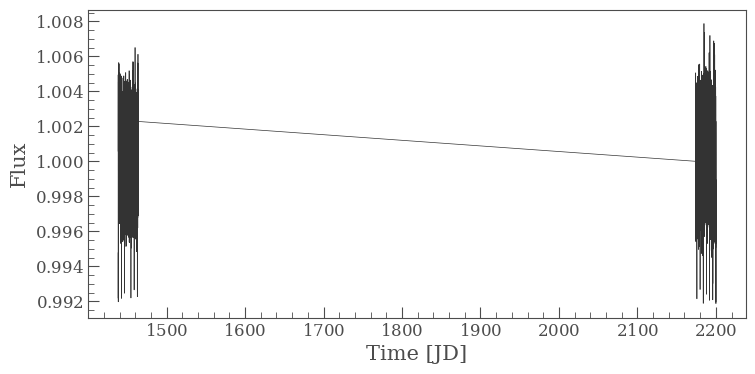

In [8]:
lc.plot()

(1437.0, 1464.0)

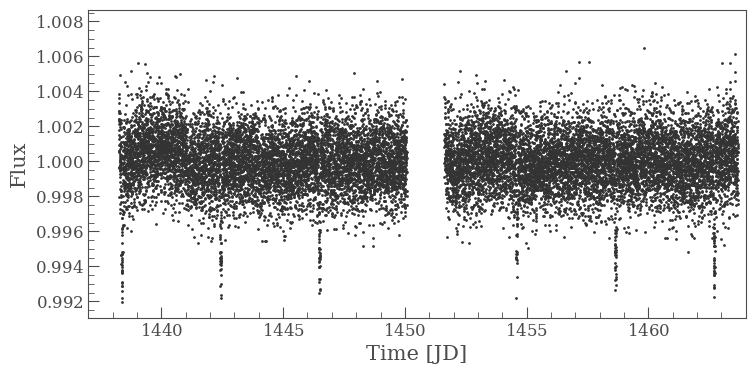

In [9]:
# sector 5
lc.scatter()
plt.xlim(1437, 1464)

(2172.0, 2201.0)

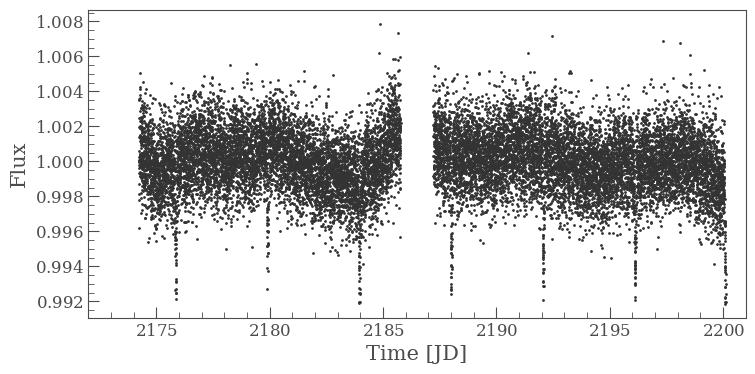

In [10]:
# sector 32
lc.scatter()
plt.xlim(2172, 2201)

In [11]:
# lets remove that last transit
lc = lc.truncate(after=2199.50)

<Axes: xlabel='Phase [JD]', ylabel='Flux'>

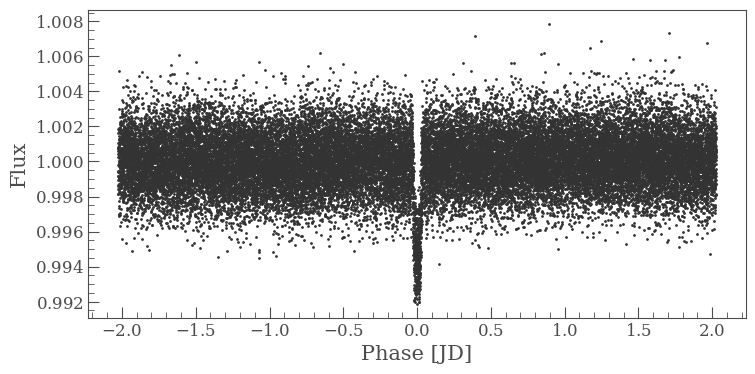

In [12]:
lc.fold(period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter()

In [13]:
# # lets bin to 5 min for faster computation
# lc_binned = lc.bin(time_bin_size=5*u.min.to(u.day)).remove_nans()
# lc_binned.to_csv('./data/toi442/lc_5min.csv')

# read the binned lightcurve
read_file_binned = pd.read_csv('./data/toi442/lc_5min.csv')
lc_binned = lk.LightCurve(time=read_file_binned['time'], flux=read_file_binned['flux'], flux_err=read_file_binned['flux_err'])

time = lc.time.value
flux = lc.flux.value
flux_err = lc.flux_err.value
inds = np.argsort(time)
time = np.ascontiguousarray(time[inds], dtype=np.float64)
flux = np.ascontiguousarray(flux[inds], dtype=np.float64)
flux_err = np.ascontiguousarray(flux_err[inds], dtype=np.float64)

time_5min = lc_binned.time.value
flux_5min = lc_binned.flux.value
flux_err_5min = lc_binned.flux_err.value
inds5 = np.argsort(time_5min)
time_5min = np.ascontiguousarray(time_5min[inds5], dtype=np.float64)
flux_5min = np.ascontiguousarray(flux_5min[inds5], dtype=np.float64)
flux_err_5min = np.ascontiguousarray(flux_err_5min[inds5], dtype=np.float64)



# get the exptimes
texp = 2.0 / 60.0 / 24.0
texp_binned = 5.0 / 60.0 / 24.0

ref_time = np.min(time)

In [14]:
# we're gonna split the lightcurves in 2 parts, sector 5, and sector 32
# lets creat another variable to store the sector of each point, then the sector ID will be 0, 1
# same as we did with different instruments in RVs
# sector 5 -> time < 1800
# sector 32 -> 1800 < time 

# 2min cadence
sector_id = np.zeros(len(time), dtype=int)
sector_id[time < 1800] = 0
sector_id[time > 1800] = 1

# 5min cadence
sector_id_5min = np.zeros(len(time_5min), dtype=int)
sector_id_5min[time_5min < 1800] = 0
sector_id_5min[time_5min > 1800] = 1

sector_id_names = ['Sector_5', 'Sector_32']

### TESS TLS

In [15]:
from transitleastsquares import transit_mask
import pickle

In [16]:
# load the results from the TLS
with open('./results/tls/tls_complete_442.pkl', 'rb') as f:
    results = pickle.load(f)

In [17]:
print(results['period'], results['T0'], results['duration'], results['depth'], results['SDE'])
tls_p = results['period']
tls_t0 = results['T0']
tls_duration = results['duration']
tls_depth = results['depth']

4.05207220998396 1438.3808123817212 0.003499671379386358 0.9948902960237005 64.36412438677563


### Transit masks

In [18]:
tls_duration*24

0.08399211310527259

(1446.0, 1447.0)

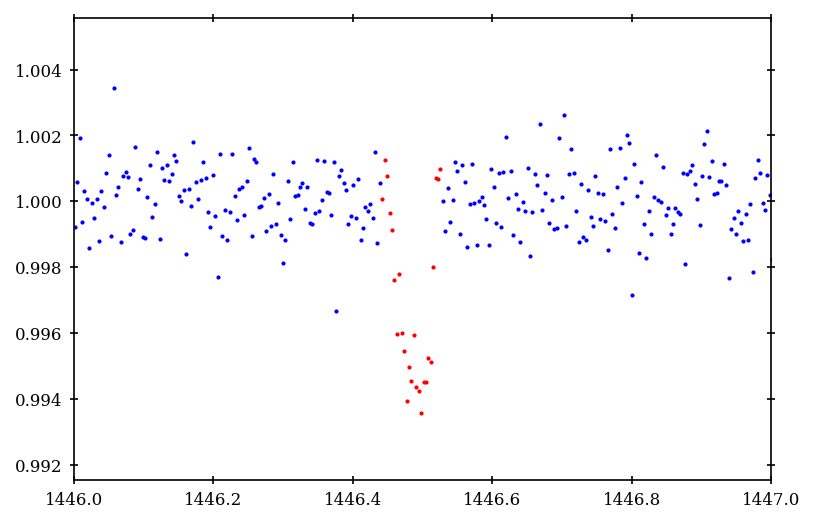

In [19]:
# 1 day around the transits for faster modeling
intransit_5min = transit_mask(time_5min, tls_p, 1, tls_t0)
intransit = transit_mask(time, tls_p, 1, tls_t0)
# just the transits 5min
intransit_5min_small = transit_mask(time_5min, tls_p, tls_duration*25, tls_t0) # only the transits
intransit_small = transit_mask(time, tls_p, tls_duration*25, tls_t0)
# just the transits 120s
in_transit = transit_mask(time, tls_p, tls_duration*25, tls_t0)

plt.scatter(time_5min[intransit_5min_small], flux_5min[intransit_5min_small], s=1, color='red')  # in-transit points in red
plt.scatter(time_5min[~intransit_5min_small], flux_5min[~intransit_5min_small], s=1, color='blue')  # other points in blue
plt.xlim(1437, 1464)
#plt.xlim(1462, 1463)
plt.xlim(1446, 1447)

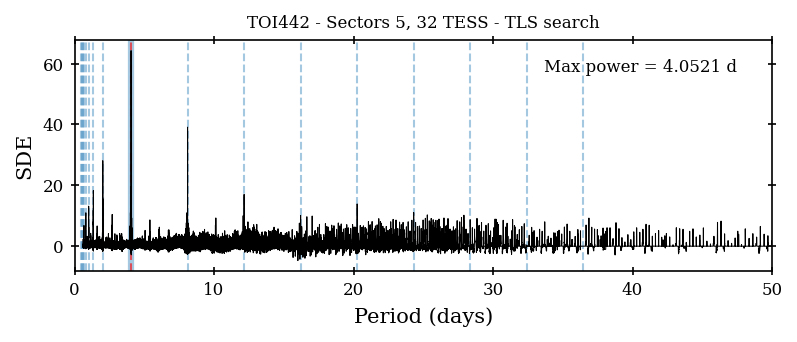

In [20]:
plt.figure(figsize=(6, 2))
ax = plt.gca()
ax.axvline(tls_p, alpha=0.4, lw=3)
ax.axvline(period_tess.nominal_value, ls='--', alpha=0.6, lw=1, color='red')
plt.xlim(np.min(results['periods']), np.max(results['periods']))
for n in range(2, 10):
    ax.axvline(n*tls_p, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(tls_p / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results['periods'], results['power'], color='black', lw=0.5)
plt.xlim(0, 50)
plt.text(.95, .92, 'Max power = {k:.4f} d'.format(k=tls_p), fontsize=8, 
         ha='right', va='top', transform=ax.transAxes)
plt.title('TOI442 - Sectors 5, 32 TESS - TLS search')
plt.savefig(f'./plots/toi442/tls1-{star_name}.png', dpi=200, bbox_inches='tight', pad_inches=0.1)

Text(0, 0.5, 'Relative flux')

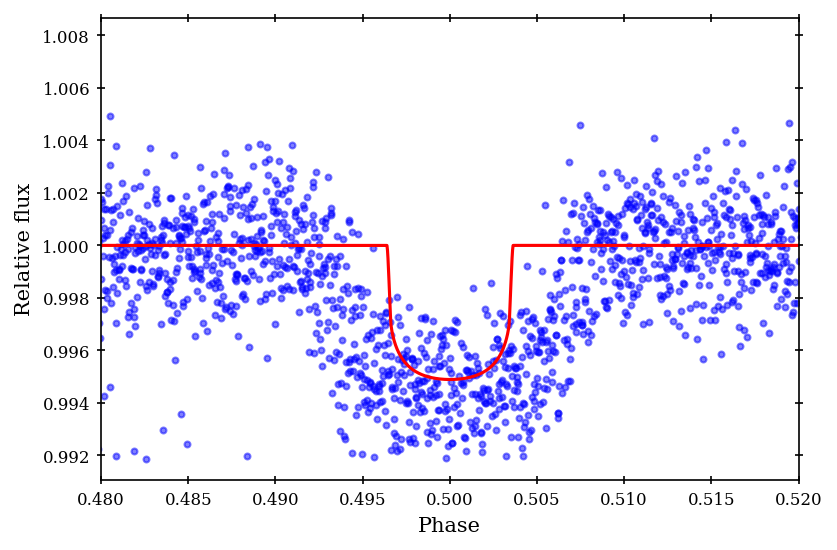

In [21]:
# results phase folded
plt.figure()
plt.scatter(results['folded_phase'], results['folded_y'], color='blue', s=8, alpha=0.5, zorder=2)
plt.plot(results['model_folded_phase'], results['model_folded_model'], color='red')
plt.xlim(0.48, 0.52)
plt.xlabel('Phase')
plt.ylabel('Relative flux')

In [22]:
tls_duration*25

0.08749178448465895

In [23]:
duration_tess/24

0.06502136604977916

(1454.0, 1455.0)

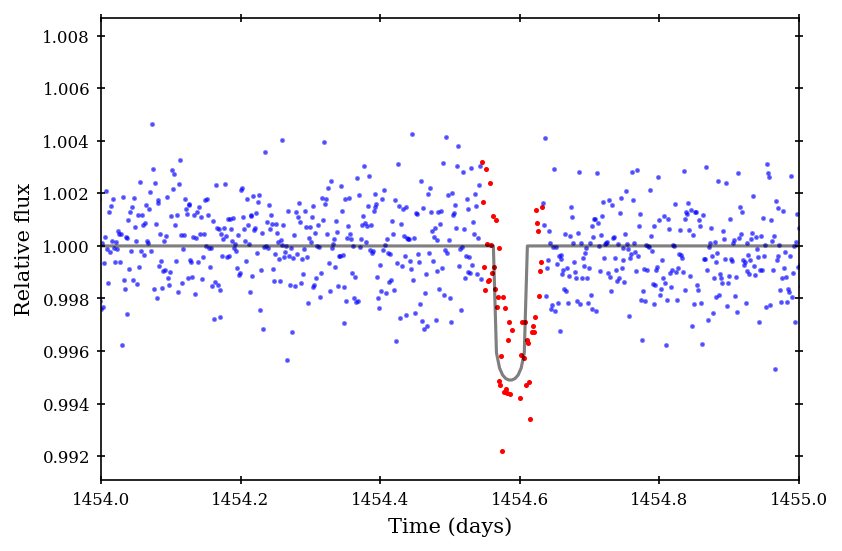

In [24]:
# complete light curve
plt.figure()
plt.scatter(lc.time.value[intransit_small], lc.flux[intransit_small], color='red', s=2, zorder=0)
plt.scatter(lc.time.value[~intransit_small], lc.flux[~intransit_small], color='blue', alpha=0.5, s=2, zorder=0)
plt.plot(results['model_lightcurve_time'], results['model_lightcurve_model'], alpha=0.5, color='k', zorder=1)
plt.xlim(lc.time.value.min(), lc.time.value.max())
plt.xlabel('Time (days)')
plt.ylabel('Relative flux');
plt.xlim(1454,1455)

Period 4.05207 d at T0= 1438.3808123817212
The number of transits with intransit data points 12
The number of transits with no intransit data points 176
Transit depth 0.99489 (at the transit bottom)
Transit duration (hours) 0.08749
Transit depths (mean) 5.329752961794498 ppt


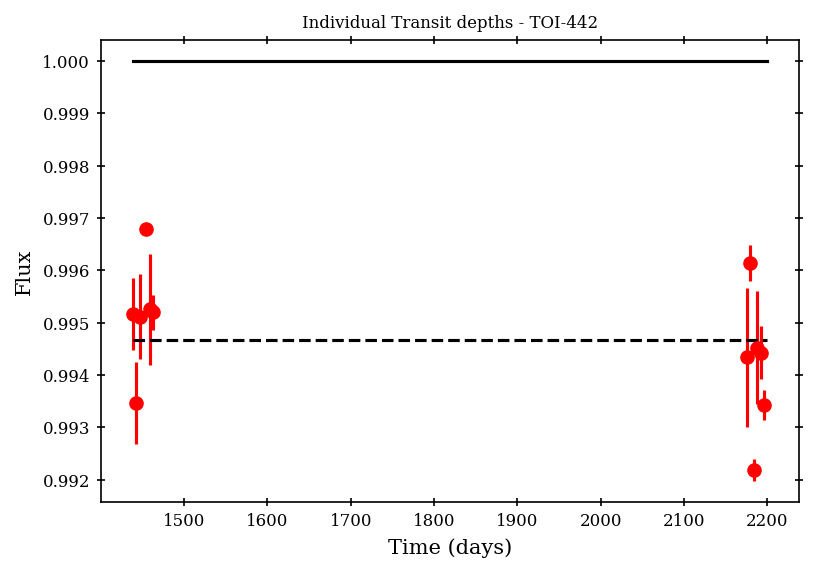

In [25]:
print('Period', format(tls_p,'.5f'), 'd at T0=', tls_t0)
# print(len(results.transit_times), 'transit times in time series:', ['{0:0.5f}'.format(i) for i in results.transit_times])
# print('Number of data points during each unique transit', results.per_transit_count)
print('The number of transits with intransit data points', results['distinct_transit_count'])
print('The number of transits with no intransit data points', results['empty_transit_count'])
print('Transit depth', format(results['depth'], '.5f'), '(at the transit bottom)')
print('Transit duration (hours)', format(tls_duration*25, '.5f'))
print('Transit depths (mean)', (1-np.nanmean(results['transit_depths']))*1e3, 'ppt')

plt.figure()
plt.errorbar(
    results['transit_times'],
    results['transit_depths'],
    yerr=results['transit_depths_uncertainties'],
    fmt='o', color='red')
plt.plot(
    (time.min(), time.max()),
    (np.nanmean(results['transit_depths']), np.nanmean(results['transit_depths'], dtype=np.float64)),
     color='black', linestyle='dashed')
plt.plot((time.min(), time.max()), (1, 1), color='black')
plt.xlabel('Time (days)')
plt.ylabel('Flux');
plt.title(f'Individual Transit depths - {star_name}')
plt.savefig(f'./plots/toi442/transit_depths_{star_name}.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

### GLS TESS Analysis

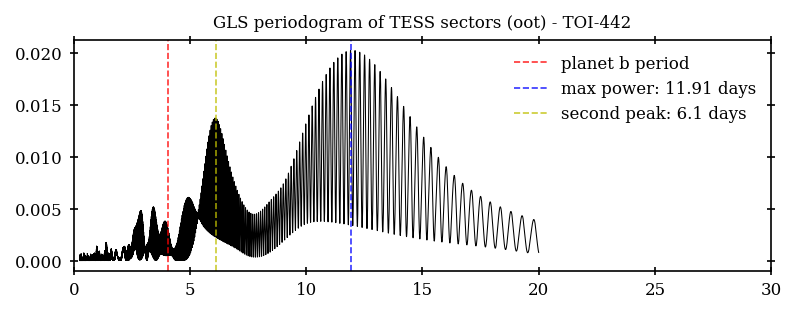

In [26]:
# first remove in-transit points from results 1
lslc = ls(lc.time.value[~intransit_small], lc.flux[~intransit_small], lc.flux_err[~intransit_small])
lc_freq, lc_power = lslc.autopower(minimum_frequency=0.05, maximum_frequency=4, samples_per_peak=50)

# # plot the periodogram
fig, ax = plt.subplots(1, 1, figsize=(6,2), dpi=150)
ax.plot(1/lc_freq, lc_power, color='k', linewidth=0.5)
ax.set_xlim(0,30)
#ax.set_ylim(0, 0.01)
ax.axvline(period_tess.nominal_value, color='r', linestyle='--', linewidth=0.8, alpha=0.8, label='planet b period')
ax.axvline(1/lc_freq[np.argmax(lc_power)], color='b', linestyle='--', linewidth=0.8, alpha=0.8, 
           label='max power: '+str(np.round(1/lc_freq[np.argmax(lc_power)],2))+' days')
ax.axvline(6.1, color='y', linestyle='--', linewidth=0.8, alpha=0.8, 
           label='second peak: '+str(np.round(6.1,2))+' days')
ax.legend(frameon=False, markerscale=0)
ax.set_title(f'GLS periodogram of TESS sectors (oot) - {star_name}')
plt.savefig(f'./plots/toi442/tess_oot_gls_{star_name}.png', dpi=200, bbox_inches='tight', pad_inches=0.1)

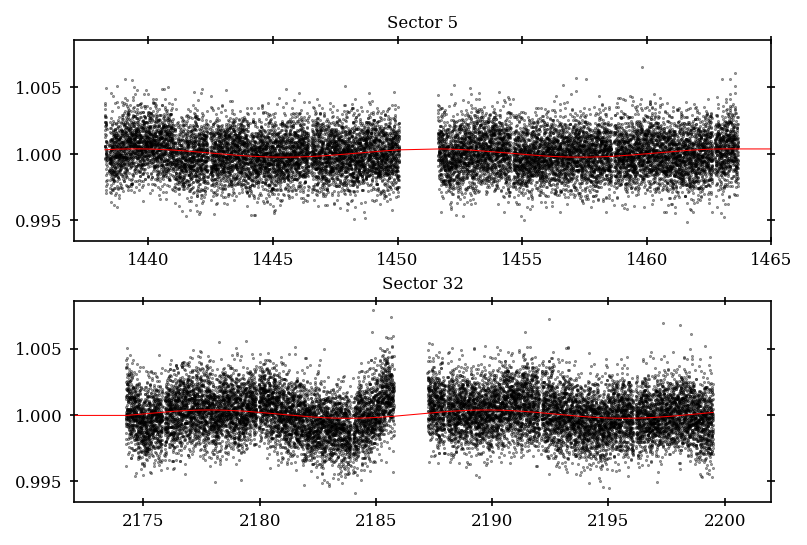

In [27]:
y_fit = lslc.model(lc.time.value[~intransit_small], lc_freq[np.argmax(lc_power)])
fig, ax = plt.subplots(2, 1, figsize=(6,4), dpi=150)
fig.subplots_adjust(hspace=0.3)
ax[0].plot(lc.time.value[~intransit_small], y_fit, color='r', linewidth=0.5)
ax[0].set_xlim(1437,1465)
ax[0].scatter(lc.time.value[~intransit_small], lc.flux[~intransit_small], color='k', s=0.2, alpha=0.5)
ax[0].set_title('Sector 5')

ax[1].plot(lc.time.value[~intransit_small], y_fit, color='r', linewidth=0.5)
ax[1].set_xlim(2172,2202)
ax[1].scatter(lc.time.value[~intransit_small], lc.flux[~intransit_small], color='k', s=0.2, alpha=0.5)
ax[1].set_title('Sector 32')
plt.savefig(f'./plots/toi442/tess-modulation_{star_name}.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [28]:
# compare rms of residuals and rms of data
rms_data = np.std(lc.flux[~intransit_small])
rms_res = np.std(lc.flux[~intransit_small] - y_fit)
print(rms_data*1e3, rms_res*1e3)

1.555610481842187 1.5396679096971424


## Modelo 

### Model variables

In [29]:
def get_xy(time_exp, version='short'):
    # parametros
    # ----------
    # time_exp: '120', '300' (int)
    # devuelve
    # ----------
    # x, y, yerr, texp (en días y ppt)
    if version == 'all':
        if time_exp == 120:
            t_ = time
            flux_ = flux
            flux_err_ = flux_err
            texp_ = texp
            id_ = sector_id
        elif time_exp == 300:
            t_ = time_5min
            flux_ = flux_5min
            flux_err_ = flux_err_5min
            texp_ = texp_binned
            id_ = sector_id_5min
    elif version == '1day':
        if time_exp == 120:
            t_ = time[intransit]
            flux_ = flux[intransit]
            flux_err_ = flux_err[intransit]
            texp_ = texp
            id_ = sector_id[intransit]
        elif time_exp == 300:
            t_ = time_5min[intransit_5min]
            flux_ = flux_5min[intransit_5min]
            flux_err_ = flux_err_5min[intransit_5min]
            texp_ = texp_binned
            id_ = sector_id_5min[intransit_5min]
    elif version == 'no-transits':
        if time_exp == 120:
            t_ = time[~intransit_small]
            flux_ = flux[~intransit_small]
            flux_err_ = flux_err[~intransit_small]
            texp_ = texp
            id_ = sector_id[~intransit_small]
        elif time_exp == 300:
            t_ = time_5min[~intransit_5min_small]
            flux_ = flux_5min[~intransit_5min_small]
            flux_err_ = flux_err_5min[~intransit_5min_small]
            texp_ = texp_binned
            id_ = sector_id_5min[~intransit_5min_small]


    x_ = np.ascontiguousarray(t_ - ref_time, dtype=np.float64)
    y_ = np.ascontiguousarray(1e3 * (flux_ - 1.0), dtype=np.float64) # Here we convert flux to ppt
    yerr_ = np.ascontiguousarray(1e3 * flux_err_, dtype=np.float64) 
    return x_, y_, yerr_, texp_, id_

## GP in LC

In [30]:
# lc para modelo

# 5-min lc
# x_, y_, yerr_, texp_, id_ = get_xy(300, 'no-transits')
# x_c, y_c, yerr_c, texp_c, id_c = get_xy(300, 'all')
# print(len(x_), len(x_c))

# 2-min lc
x_, y_, yerr_, texp_, id_ = get_xy(120, 'no-transits')
x_c, y_c, yerr_c, texp_c, id_c = get_xy(120, 'all')
print(len(x_), len(x_c))

33401 34136


In [31]:
# # Prior analysis of noise GP on full 5-min LC to get the priors for joint model
with pm.Model() as model_lcgp:
    # LC jitter & GP parameters
    sigma_lc_ = pm.Uniform("sigma_lc_", lower=0, upper=10)
    rho_gp_ = pm.Uniform("rho_gp_", lower=0, upper=10)
    sigma_gp_ = pm.Uniform("sigma_gp_", lower=0, upper=10)

    kernel = terms.SHOTerm(
        sigma=sigma_gp_,
        rho=rho_gp_,
        Q=1 / np.sqrt(2))

    err_lc = pt.sqrt(yerr_**2 + sigma_lc_**2)
    gp_lc = GaussianProcess(kernel, t=x_, mean=0.0, yerr=sigma_lc_)
    gp_lc.marginal("obs_lc", observed=y_)
    pm.Deterministic("gp_lc_pred", gp_lc.predict(y_))
    pm.Deterministic("gp_lc_pred_complete", gp_lc.predict(y_, t=x_c))
    
    map_soln_tess = pm.find_MAP()

Output()

In [32]:
for key, value in map_soln_tess.items():
    if 'pred' not in key and 'interval' not in key:
        print(key,'= ', f'{value:.3f}')

timescale = map_soln_tess['rho_gp_']/(np.sqrt(2)*np.pi)
print(f'timescale = {timescale:.3f}')

sigma_lc_ =  1.491
rho_gp_ =  2.045
sigma_gp_ =  0.467
timescale = 0.460


In [33]:
# sigma_lc_ =  1.491
# rho_gp_ =  2.045
# sigma_gp_ =  0.467
# timescale = 0.460

(730.0, 765.0)

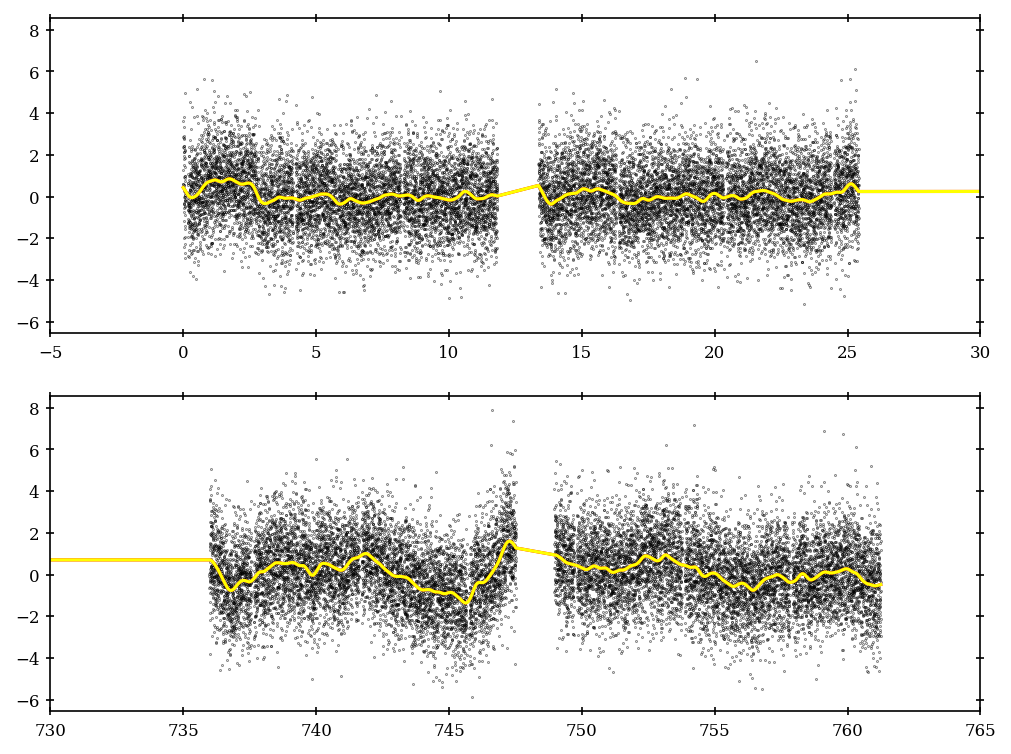

In [34]:
fig, axs = plt.subplots(len(sector_id_names), 1, figsize=(8, 6), dpi=150)
gp = map_soln_tess['gp_lc_pred']
gp_complete = map_soln_tess['gp_lc_pred_complete']

for i, name in enumerate(sector_id_names):
    ax = axs[i]
    # first plot the lc model with GP
    ax.plot(x_, y_, ".k", ms=0.4, label=f'{name}')
    ax.plot(x_, gp, label="gp model {}".format(name), color='red')
    ax.plot(x_c, gp_complete, label='gp complete', color='yellow')
axs[0].set_xlim(-5,30)
axs[1].set_xlim(730,765)

In [35]:
# since we don't need uncertainties, sampling serves no purpose here
# it's better to just optimize with MAP and get the point estimate of maximum likelihood

# with model_lcgp:
#     trace_gp_tess = pm.sample(
#         tune=1500,
#         draws=1500,
#         initvals=map_soln_tess,
#         target_accept=0.95,
#         init="adapt_full",
#         chains=2,
#         random_seed=42,
#         )

In [36]:
# # trace to save
# az.to_netcdf(trace_gp_tess, './saves/toi442/trace_lcgp_sho_1gp.save') 

# # save to trace
# #trace_gp_tess = az.from_netcdf('./saves/toi442/trace_lcgp_sho_1gp.save')

In [37]:
# flat_samps_gptess = trace_gp_tess.posterior.stack(sample=("chain", "draw"))

In [38]:
# fig, axs = plt.subplots(len(sector_id_names), 1, figsize=(8, 6), dpi=150)
# gp = flat_samps_gptess['gp_lc_pred'].median(axis=-1).values
# gp_complete = flat_samps_gptess['gp_lc_pred_complete'].median(axis=-1).values

# for i, name in enumerate(sector_id_names):
#     ax = axs[i]
#     # first plot the lc model with GP
#     ax.plot(x_, y_, ".k", ms=0.4, label=f'{name}')
#     ax.plot(x_, gp, label="gp model {}".format(name), color='red')
#     ax.plot(x_c, gp_complete, label='gp complete', color='yellow')
# axs[0].set_xlim(-5,30)
# axs[1].set_xlim(730,765)

In [39]:
# vars_gp_tess = ['rho_gp_', 'sigma_gp_', 'sigma_lc_']

# summary = az.summary(trace_gp_tess, stat_funcs={'median': np.median, 'std':np.std}, 
#                      hdi_prob=0.68, round_to=6, stat_focus='median', var_names=vars_gp_tess)
# summary

In [40]:
# # # # traceplot
# az.plot_trace(trace_gp_tess, compact=True, var_names=vars_gp_tess)
# plt.subplots_adjust(hspace=0.5)
# plt.show()

In [41]:
params_gptess = {}
with open(f'./results/toi442/gp_lc_tess_2min.txt', 'w') as f:
    for var, value in map_soln_tess.items():
        if 'pred' not in var and 'interval' not in var:
            f.write(f'{var} = {value:.6f}\n')
            print(var, " = {r:.6f}".format(r=value))
            if 'rho' in var:
                timescale = value/(np.sqrt(2)*np.pi)
                print(f'timescale = {timescale:.3f}')
                f.write(f'timescale = {timescale:.3f}\n')

f.close()     

sigma_lc_  = 1.491444
rho_gp_  = 2.045268
timescale = 0.460
sigma_gp_  = 0.466747


## Detrend and save LC

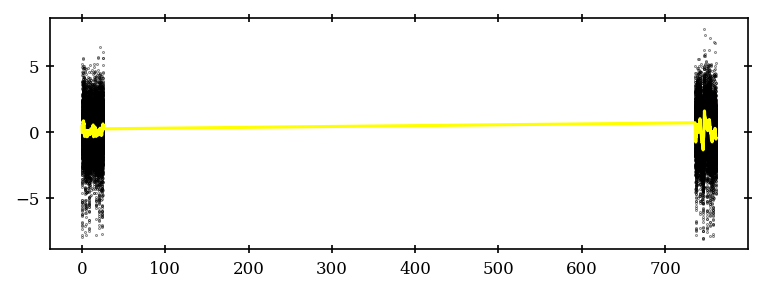

In [42]:
plt.figure(figsize=(6, 2), dpi=150)
plt.plot(x_c, gp_complete, label='gp complete', color='yellow', zorder=100)
plt.plot(x_c, y_c, ".k", ms=0.4, label='data')

1.6524722058334687
1.5873310377001777


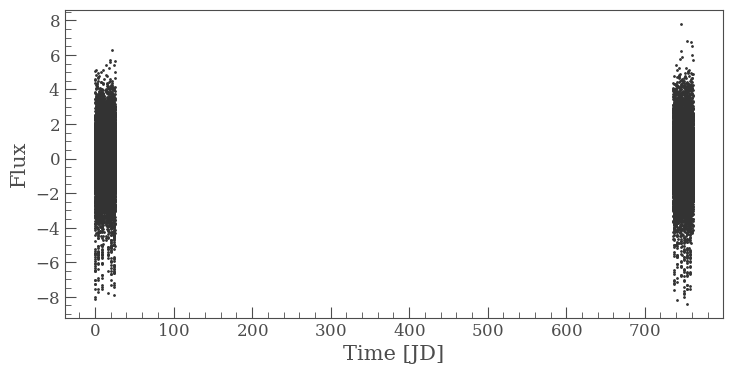

In [43]:
detrended_lc = lk.LightCurve(time=x_c, flux=y_c-gp_complete, flux_err=yerr_c)
detrended_lc.scatter()
print(np.std(y_c))
print(np.std(y_c-gp_complete))

In [ ]:
# save
#detrended_lc.to_csv('./data/toi442/detrended_lc_2min.csv', overwrite=True)

In [ ]:
# # save gp predictions
# gp_lc = lk.LightCurve(time=x_c, flux=gp_complete)
# gp_lc.to_csv('./data/toi442/gp_lc_2min.csv', overwrite=True)